Imports

In [1]:
import os
import csv
import spacy
import numpy as np 
import pandas as pd
import collections


<h1>Clean the CSV Files</h1>

<h2>Clean CSV Function</h2>

In [2]:
def clean_csv(filename: str):
    pass

<h2>Clean All CSVs</h2>

In [3]:
import os
import pandas as pd

csv_folder = "./CSVS/"
csv_files = os.listdir(csv_folder)

sentences_df = pd.DataFrame(columns=["TITLE", "SENTENCE", "WORD_COUNT"])


for file in csv_files:
    path = os.path.join(csv_folder, file)
    title = file.replace(".csv", "") 

    df = pd.read_csv(path)

    # Check if the "SENTENCES" column exists in the DataFrame
    if "SENTENCES" in df.columns:
        # Create a new DataFrame with titles and sentences
        temp_df = df[["SENTENCES"]].rename(columns={"SENTENCES": "SENTENCE"})
        temp_df["TITLE"] = title  # Add the title column

        # Append to the main sentences_df DataFrame
        sentences_df = pd.concat([sentences_df, temp_df], ignore_index=True)

print(sentences_df["SENTENCE"].head())




0    masking significant epistemological distinctio...
1    For in- stance, when we use the term “cognitio...
2    Similarly, when an ap- proach to learning and ...
3    All of the aforementioned theories and their i...
4    Further, such epistemological differences make...
Name: SENTENCE, dtype: object


<Axes: >

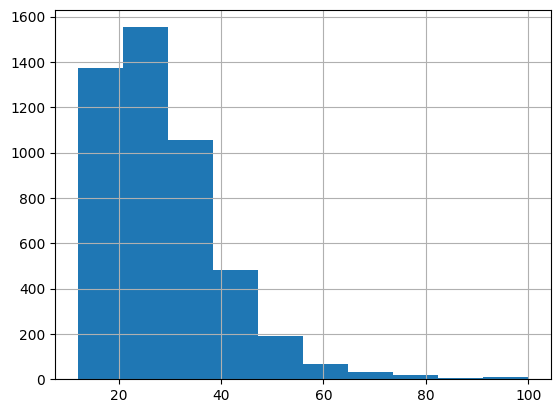

In [4]:
# Add other features 

sentences_df["TITLE"] = sentences_df["TITLE"].astype("string")
sentences_df["SENTENCE"] = sentences_df["SENTENCE"].astype("string")
sentences_df["WORD_COUNT"] = sentences_df["SENTENCE"].apply(lambda x: len(x.split(" ")))
sentences_df["WORD_COUNT"].hist()



Use Spacy to Extract Features

In [5]:

nlp = spacy.load("en_core_web_sm")

In [6]:


sentences = sentences_df["SENTENCE"]
random_sentence = np.random.choice(sentences)

def getIsStopCountAndPosTags(s: str):
    doc = nlp(s)
    is_stop_count = 0
    pos_tag_count = collections.defaultdict(int)  

    # Iterate over each token in the document
    for token in doc:
        if token.is_stop:
            is_stop_count += 1
        pos_tag_count[token.pos_] += 1  

    return is_stop_count, dict(pos_tag_count)  # Return both stop word count and POS tag dict

print(random_sentence, getIsStopCountAndPosTags(random_sentence))

# Apply the function to the dataframe, storing both stop word counts and POS tags
sentences_df["IS_STOP_COUNT"], sentences_df["POS_TAGS"] = zip(*sentences_df["SENTENCE"].apply(getIsStopCountAndPosTags))



If there is no place for the existence of a concept or the formation of concepts in any manner, thenthere is no reason to even hope for a theoretical bridging.Second, beyond the minimal test of whether there is accep- tance of conceptualization, it becomes essential to considerwhether there is a “reality” or “truth” to which a person’s orgroup’s understanding can be judged (40, {'SCONJ': 2, 'PRON': 5, 'VERB': 7, 'DET': 10, 'NOUN': 16, 'ADP': 9, 'CCONJ': 2, 'PUNCT': 8, 'ADV': 3, 'AUX': 3, 'PART': 4, 'ADJ': 4})


In [7]:
len(sentences_df)

4786

In [11]:
path="EXTRACTED_SENTENCE_DATA.csv"
sentences_df.to_csv(path)



In [ ]:
df_test = pd.read_csv(f'{path}')
df_test.head()

df_test["STOP_PERCENTAGE"] = df_test["IS_STOP_COUNT"]/ df_test["WORD_COUNT"]

Scratch Work

TODO: NOUN SUBJECT AND NOUN OBJECTS